## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample

from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import binarize

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [5]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(10)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
17297,00004644_002.png,No Finding,2,4644,23,F,PA,2048,2500,0.171,0.171,NaN,/data/images_003/images/00004644_002.png
30975,00008053_005.png,Atelectasis,5,8053,61,M,PA,2992,2991,0.143,0.143,NaN,/data/images_004/images/00008053_005.png
19622,00005216_007.png,No Finding,7,5216,62,F,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00005216_007.png
93167,00023283_016.png,Pneumothorax,16,23283,50,F,PA,2516,2758,0.143,0.143,NaN,/data/images_010/images/00023283_016.png
92058,00022977_009.png,Effusion|Infiltration|Mass|Nodule|Pleural_Thic...,9,22977,43,M,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00022977_009.png
31231,00008141_000.png,No Finding,0,8141,19,F,PA,2048,2500,0.168,0.168,NaN,/data/images_004/images/00008141_000.png
60883,00015031_019.png,Infiltration,19,15031,40,F,AP,3056,2544,0.139,0.139,NaN,/data/images_007/images/00015031_019.png
57155,00014197_005.png,No Finding,5,14197,59,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00014197_005.png
14805,00003867_001.png,Atelectasis,1,3867,29,M,AP,2500,2048,0.171,0.171,NaN,/data/images_002/images/00003867_001.png
86908,00021449_005.png,No Finding,5,21449,52,F,PA,2690,2991,0.143,0.143,NaN,/data/images_010/images/00021449_005.png


In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(20)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
41427,00010711_003.png,No Finding,3,10711,34,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9679,00002509_021.png,Infiltration,21,2509,44,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
47405,00012045_037.png,Atelectasis,37,12045,46,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45647,00011702_021.png,Infiltration,21,11702,25,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
17688,00004772_001.png,Effusion,1,4772,43,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53377,00013472_006.png,Effusion,6,13472,74,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56594,00014082_002.png,No Finding,2,14082,36,F,PA,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
91173,00022730_000.png,Mass|Pneumothorax,0,22730,18,F,PA,2658,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
75192,00018448_012.png,Atelectasis|Infiltration,12,18448,41,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
68889,00016990_000.png,Cardiomegaly,0,16990,65,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
all_xray_df['path'].head()

0    /data/images_001/images/00000001_000.png
1    /data/images_001/images/00000001_001.png
2    /data/images_001/images/00000001_002.png
3    /data/images_001/images/00000002_000.png
4    /data/images_001/images/00000003_000.png
Name: path, dtype: object

In [8]:
len(all_xray_df['Patient ID'].unique())

30805

In [9]:
all_xray_df=all_xray_df[all_xray_df['View Position']=='PA']

In [10]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
len(all_xray_df['Image Index'].unique())

67310

In [12]:
len(all_xray_df['Patient ID'].unique())

28868

In [13]:
len(all_xray_df)

67310

In [14]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

## Create your training and testing data:

In [ ]:
# def create_splits(vargs):
    
#     ## Either build your own or use a built-in library to split your original dataframe into two sets 
#     ## that can be used for training and testing your model
#     ## It's important to consider here how balanced or imbalanced you want each of those sets to be
#     ## for the presence of pneumonia
    
#     # Todo
    
#     return train_data, val_data

In [15]:

train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])

In [16]:
train_df['Pneumonia'].sum()/len(train_df)

0.009359679096716684

In [17]:

valid_df['Pneumonia'].sum()/len(valid_df)

0.009359679096716684

In [18]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
73910,00018182_007.png,No Finding,7,18182,29,F,PA,2536,2635,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55746,00013950_004.png,Atelectasis,4,13950,64,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68672,00016953_001.png,No Finding,1,16953,61,F,PA,2602,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
42551,00010953_006.png,Pleural_Thickening,6,10953,57,F,PA,2594,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
109379,00029754_000.png,No Finding,0,29754,52,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
train_df.shape

(53848, 28)

In [20]:
train_df[(train_df['Infiltration']==0) & (train_df['Effusion']==0) & (train_df['Pneumonia']==0) & (train_df['Edema']==0) & (train_df['Atelectasis']==0) ]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
73910,00018182_007.png,No Finding,7,18182,29,F,PA,2536,2635,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
68672,00016953_001.png,No Finding,1,16953,61,F,PA,2602,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
42551,00010953_006.png,Pleural_Thickening,6,10953,57,F,PA,2594,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
109379,00029754_000.png,No Finding,0,29754,52,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
37905,00009962_005.png,No Finding,5,9962,56,M,PA,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74100,00018224_002.png,No Finding,2,18224,58,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12086,00003149_001.png,No Finding,1,3149,40,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
93145,00023279_000.png,No Finding,0,23279,39,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60044,00014822_019.png,No Finding,19,14822,58,F,PA,2686,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
train_df[train_df.Pneumonia==1].shape

(504, 28)

In [22]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
#considering co-occurences might harm the purity of negative class
np_inds = train_df[ (train_df['Pneumonia']==0) ].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [23]:

train_df['Pneumonia'].sum()/len(train_df)

0.5

Assuming 20% prevalence of pneumonia in real world setting

In [24]:
valid_df


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
98614,00026072_018.png,Effusion,18,26072,35,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48243,00012233_000.png,No Finding,0,12233,24,F,PA,2378,2769,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
56394,00014028_001.png,Nodule,1,14028,69,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
81,00000013_043.png,Mass|Pleural_Thickening,43,13,56,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8933,00002351_002.png,No Finding,2,2351,48,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47163,00012017_000.png,No Finding,0,12017,41,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
24822,00006519_006.png,No Finding,6,6519,58,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55141,00013810_000.png,Atelectasis|Pneumothorax,0,13810,77,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
107929,00029189_001.png,No Finding,1,29189,57,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[ (valid_df['Pneumonia']==0) ].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [26]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

In [27]:
train_df.shape

(1008, 28)

In [28]:
valid_df.shape

(630, 28)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

# Image Data Augmentation

In [ ]:
# def my_image_augmentation(vargs):
    
#     ## recommendation here to implement a package like Keras' ImageDataGenerator
#     ## with some of the built-in augmentations 
    
#     ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
#     ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
#     ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
#     ## built into something like a Keras package
    
#     # Todo
    
#     return my_idg


# def make_train_gen(vargs):
    
#     ## Create the actual generators using the output of my_image_augmentation for your training data
#     ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
# #     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
# #                                          directory=None, 
# #                                          x_col = ,
# #                                          y_col = ,
# #                                          class_mode = 'binary',
# #                                          target_size = , 
# #                                          batch_size = 
# #                                          )
#      # Todo

#     return train_gen


# def make_val_gen(vargs):
    
# #     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
# #                                              directory=None, 
# #                                              x_col = ,
# #                                              y_col = ',
# #                                              class_mode = 'binary',
# #                                              target_size = , 
# #                                              batch_size = ) 
    
#     # Todo
#     return val_gen

In [29]:
imgs = train_df.path

In [30]:
imgs

53793    /data/images_006/images/00013591_005.png
11856    /data/images_002/images/00003092_000.png
87576    /data/images_010/images/00021627_007.png
59681    /data/images_007/images/00014731_016.png
86371    /data/images_010/images/00021294_005.png
                           ...                   
90481    /data/images_010/images/00022526_004.png
48882    /data/images_006/images/00012381_008.png
44184    /data/images_005/images/00011380_005.png
43039    /data/images_005/images/00011111_000.png
75303    /data/images_009/images/00018477_000.png
Name: path, Length: 1008, dtype: object

In [31]:
len(imgs)

1008

In [32]:
train_df['Pneumonia_class']=train_df['Pneumonia']

In [33]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
53793,00013591_005.png,Effusion|Pneumonia,5,13591,53,M,PA,2992,2985,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11856,00003092_000.png,Pneumonia,0,3092,53,M,PA,2758,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
87576,00021627_007.png,Pneumonia,7,21627,43,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
59681,00014731_016.png,Emphysema|Mass|Pneumonia|Pneumothorax,16,14731,54,M,PA,2878,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
86371,00021294_005.png,Infiltration|Pneumonia,5,21294,57,M,PA,2544,3056,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [34]:
train_df['Pneumonia_class']=train_df['Pneumonia_class'].replace(1,'YES').replace(0,'NO')

In [35]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
53793,00013591_005.png,Effusion|Pneumonia,5,13591,53,M,PA,2992,2985,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
11856,00003092_000.png,Pneumonia,0,3092,53,M,PA,2758,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
87576,00021627_007.png,Pneumonia,7,21627,43,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
59681,00014731_016.png,Emphysema|Mass|Pneumonia|Pneumothorax,16,14731,54,M,PA,2878,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,YES
86371,00021294_005.png,Infiltration|Pneumonia,5,21294,57,M,PA,2544,3056,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90481,00022526_004.png,Effusion,4,22526,49,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NO
48882,00012381_008.png,No Finding,8,12381,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NO
44184,00011380_005.png,Effusion,5,11380,67,M,PA,2754,2890,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NO
43039,00011111_000.png,No Finding,0,11111,55,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NO


In [36]:
IMG_SIZE = (224, 224)

In [37]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)



In [38]:
train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 20)
                                         
                                         

Found 1008 validated image filenames belonging to 2 classes.


In [39]:
valid_df['Pneumonia_class']=valid_df['Pneumonia']

In [40]:
valid_df['Pneumonia_class']=valid_df['Pneumonia_class'].replace(1,'YES').replace(0,'NO')

In [41]:
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32)

Found 630 validated image filenames belonging to 2 classes.


In [42]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

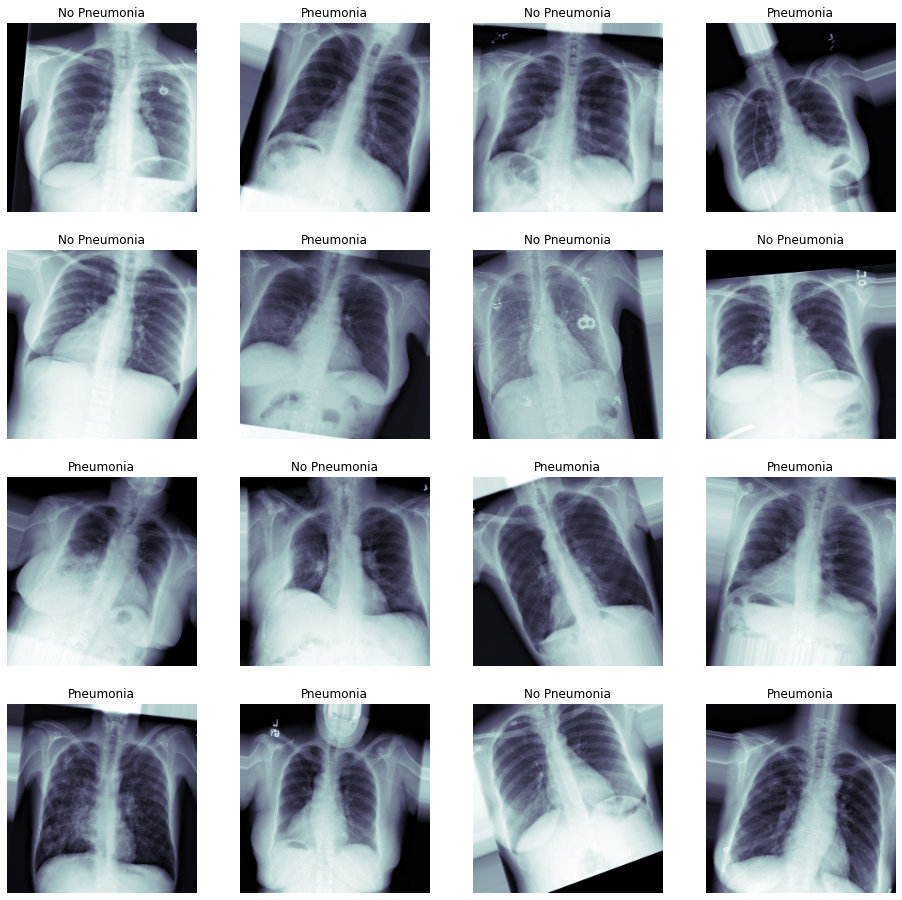

In [43]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

# VGG16

In [ ]:
# def load_pretrained_model(vargs):
    
#     # model = VGG16(include_top=True, weights='imagenet')
#     # transfer_layer = model.get_layer(lay_of_interest)
#     # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
#     # Todo
    
#     return vgg_model


In [44]:

model = VGG16(include_top=True, weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [45]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [46]:
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [47]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [ ]:
# def build_my_model(vargs):
    
#     # my_model = Sequential()
#     # ....add your pre-trained model, and then whatever additional layers you think you might
#     # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
#     # if you want to compile your model within this function, consider which layers of your pre-trained model, 
#     # you want to freeze before you compile 
    
#     # also make sure you set your optimizer, loss function, and metrics to monitor
    
#     # Todo
    
#     return my_model



# ## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
# ## to output class activation maps to aid in clinical interpretation of your model's results

# ARCHITECTURE 1

In [48]:

new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [49]:
optimizer = Adam(lr=1e-4, decay= 0.1)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [50]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [51]:
new_model.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 10)

Epoch 1/10
51/51 [==============================] - 31s 610ms/step - loss: 0.7157 - binary_accuracy: 0.5149 - val_loss: 0.6525 - val_binary_accuracy: 0.6875
Epoch 2/10
51/51 [==============================] - 25s 490ms/step - loss: 0.7196 - binary_accuracy: 0.5218 - val_loss: 0.6745 - val_binary_accuracy: 0.5938
Epoch 3/10
51/51 [==============================] - 26s 517ms/step - loss: 0.6946 - binary_accuracy: 0.5377 - val_loss: 0.6893 - val_binary_accuracy: 0.5000
Epoch 4/10
51/51 [==============================] - 26s 518ms/step - loss: 0.7062 - binary_accuracy: 0.5218 - val_loss: 0.6761 - val_binary_accuracy: 0.5938
Epoch 5/10
51/51 [==============================] - 27s 522ms/step - loss: 0.6905 - binary_accuracy: 0.5645 - val_loss: 0.6669 - val_binary_accuracy: 0.6250
Epoch 6/10
51/51 [==============================] - 27s 524ms/step - loss: 0.6994 - binary_accuracy: 0.5218 - val_loss: 0.6878 - val_binary_accuracy: 0.5312
Epoch 7/10
51/51 [==============================] - 27s 52

# ARCHITECTURE 2

In [80]:
new_model2 = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model2.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model2.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model2.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model2.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model2.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model2.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model2.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model2.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model2.add(Dense(1, activation='sigmoid'))

In [81]:
optimizer = Adam(lr=1e-4, decay=0.1)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [82]:
new_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [83]:
new_model2.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 10)

Epoch 1/10
51/51 [==============================] - 27s 532ms/step - loss: 0.8010 - binary_accuracy: 0.5218 - val_loss: 0.6306 - val_binary_accuracy: 0.6875
Epoch 2/10
51/51 [==============================] - 26s 516ms/step - loss: 0.7956 - binary_accuracy: 0.5060 - val_loss: 0.6271 - val_binary_accuracy: 0.6875
Epoch 3/10
51/51 [==============================] - 26s 514ms/step - loss: 0.7569 - binary_accuracy: 0.5198 - val_loss: 0.6285 - val_binary_accuracy: 0.6875
Epoch 4/10
51/51 [==============================] - 27s 521ms/step - loss: 0.7641 - binary_accuracy: 0.5020 - val_loss: 0.6278 - val_binary_accuracy: 0.6875
Epoch 5/10
51/51 [==============================] - 26s 514ms/step - loss: 0.7450 - binary_accuracy: 0.5139 - val_loss: 0.6313 - val_binary_accuracy: 0.6875
Epoch 6/10
51/51 [==============================] - 26s 519ms/step - loss: 0.7442 - binary_accuracy: 0.5129 - val_loss: 0.6336 - val_binary_accuracy: 0.6875
Epoch 7/10
51/51 [==============================] - 26s 51

# ARCHITECTURE 3

In [105]:
new_model3=Sequential()
new_model3.add(Conv2D(32,kernel_size=(3,3),activation='relu', input_shape=(224,224,3)))

new_model3.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
new_model3.add(MaxPooling2D(pool_size=(2,2)))
new_model3.add(Dropout(0.25))

new_model3.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
new_model3.add(MaxPooling2D(pool_size=(2,2)))
new_model3.add(Dropout(0.25))

new_model3.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
new_model3.add(MaxPooling2D(pool_size=(2,2)))
new_model3.add(Dropout(0.25))

new_model3.add(Flatten())
new_model3.add(Dense(64, activation='relu'))
new_model3.add(Dropout(0.5))


new_model3.add(Dense(1, activation='sigmoid'))


In [106]:
new_model3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [107]:
new_model3.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 10)

Epoch 1/10
51/51 [==============================] - 26s 514ms/step - loss: 0.6982 - binary_accuracy: 0.4782 - val_loss: 0.6983 - val_binary_accuracy: 0.3125
Epoch 2/10
51/51 [==============================] - 25s 484ms/step - loss: 0.6991 - binary_accuracy: 0.4812 - val_loss: 0.6980 - val_binary_accuracy: 0.3125
Epoch 3/10
51/51 [==============================] - 25s 495ms/step - loss: 0.6922 - binary_accuracy: 0.5337 - val_loss: 0.6953 - val_binary_accuracy: 0.4375
Epoch 4/10
51/51 [==============================] - 25s 499ms/step - loss: 0.6963 - binary_accuracy: 0.4861 - val_loss: 0.6906 - val_binary_accuracy: 0.6250
Epoch 5/10
51/51 [==============================] - 26s 503ms/step - loss: 0.6906 - binary_accuracy: 0.5268 - val_loss: 0.6924 - val_binary_accuracy: 0.5938
Epoch 6/10
51/51 [==============================] - 26s 500ms/step - loss: 0.6896 - binary_accuracy: 0.5159 - val_loss: 0.6916 - val_binary_accuracy: 0.6875
Epoch 7/10
51/51 [==============================] - 26s 50

# Taking Architecture 1

In [52]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_new_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [53]:
weight_path

'xray_class_new_model.best.hdf5'

### Start training! 

In [54]:
## train your model

# Todo

history = new_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =10 , 
                          callbacks = callbacks_list)

Epoch 1/10
51/51 [==============================] - 27s 528ms/step - loss: 0.6771 - binary_accuracy: 0.5784 - val_loss: 0.6894 - val_binary_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 0.68937, saving model to xray_class_new_model.best.hdf5
Epoch 2/10
51/51 [==============================] - 26s 519ms/step - loss: 0.6821 - binary_accuracy: 0.5556 - val_loss: 0.6988 - val_binary_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.68937
Epoch 3/10
51/51 [==============================] - 27s 524ms/step - loss: 0.6837 - binary_accuracy: 0.5615 - val_loss: 0.6816 - val_binary_accuracy: 0.5938

Epoch 00003: val_loss improved from 0.68937 to 0.68156, saving model to xray_class_new_model.best.hdf5
Epoch 4/10
51/51 [==============================] - 27s 520ms/step - loss: 0.6809 - binary_accuracy: 0.5615 - val_loss: 0.6936 - val_binary_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.68156
Epoch 5/10
51/51 [==============================] - 27s 527ms/st

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [55]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 3s 104ms/step


In [ ]:
# def plot_auc(t_y, p_y):
    
#     ## Hint: can use scikit-learn's built in functions here like roc_curve
    
#     # Todo
    
#     return

# ## what other performance statistics do you want to include here besides AUC? 


# # def ... 
# # Todo

# # def ...
# # Todo
    
# #Also consider plotting the history of your model training:

# def plot_history(history):
    
#     # Todo
#     return

In [56]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

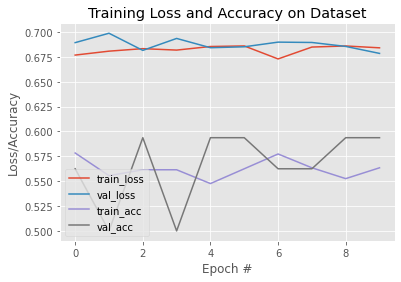

In [57]:

plot_history(history)

#  Taking Architecture 2

In [84]:
weight_path2="{}_new_model2.best.hdf5".format('xray_class')

checkpoint2 = ModelCheckpoint(weight_path2, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early2 = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list2 = [checkpoint2, early2]

In [85]:
weight_path2

'xray_class_new_model2.best.hdf5'

In [86]:
history2 = new_model2.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =10 , 
                          callbacks = callbacks_list2)

Epoch 1/10
51/51 [==============================] - 27s 531ms/step - loss: 0.7365 - binary_accuracy: 0.5188 - val_loss: 0.6330 - val_binary_accuracy: 0.6875

Epoch 00001: val_loss improved from inf to 0.63297, saving model to xray_class_new_model2.best.hdf5
Epoch 2/10
51/51 [==============================] - 26s 511ms/step - loss: 0.7443 - binary_accuracy: 0.5020 - val_loss: 0.6344 - val_binary_accuracy: 0.6875

Epoch 00002: val_loss did not improve from 0.63297
Epoch 3/10
51/51 [==============================] - 26s 511ms/step - loss: 0.7478 - binary_accuracy: 0.4940 - val_loss: 0.6332 - val_binary_accuracy: 0.6875

Epoch 00003: val_loss did not improve from 0.63297
Epoch 4/10
51/51 [==============================] - 26s 514ms/step - loss: 0.7389 - binary_accuracy: 0.5179 - val_loss: 0.6338 - val_binary_accuracy: 0.6875

Epoch 00004: val_loss did not improve from 0.63297
Epoch 5/10
51/51 [==============================] - 26s 512ms/step - loss: 0.7457 - binary_accuracy: 0.4980 - val_l

In [87]:
new_model2.load_weights(weight_path2)
pred_Y2 = new_model2.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 13ms/step


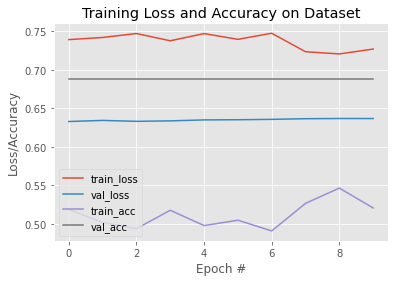

In [88]:
plot_history(history2)

# Taking Architecture 3

In [108]:
weight_path3="{}_new_model3.best.hdf5".format('xray_class')

checkpoint3 = ModelCheckpoint(weight_path3, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early3 = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list3 = [checkpoint3, early3]

In [109]:
history3 = new_model3.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =10 , 
                          callbacks = callbacks_list3)

Epoch 1/10
51/51 [==============================] - 26s 502ms/step - loss: 0.6897 - binary_accuracy: 0.5347 - val_loss: 0.6926 - val_binary_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.69259, saving model to xray_class_new_model3.best.hdf5
Epoch 2/10
51/51 [==============================] - 25s 499ms/step - loss: 0.6916 - binary_accuracy: 0.5228 - val_loss: 0.6939 - val_binary_accuracy: 0.4375

Epoch 00002: val_loss did not improve from 0.69259
Epoch 3/10
51/51 [==============================] - 26s 505ms/step - loss: 0.6897 - binary_accuracy: 0.5327 - val_loss: 0.6936 - val_binary_accuracy: 0.4688

Epoch 00003: val_loss did not improve from 0.69259
Epoch 4/10
51/51 [==============================] - 26s 501ms/step - loss: 0.6949 - binary_accuracy: 0.5040 - val_loss: 0.6922 - val_binary_accuracy: 0.5000

Epoch 00004: val_loss improved from 0.69259 to 0.69220, saving model to xray_class_new_model3.best.hdf5
Epoch 5/10
51/51 [==============================] - 25s 495ms/

In [110]:
new_model3.load_weights(weight_path3)
pred_Y3 = new_model3.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 1s 29ms/step


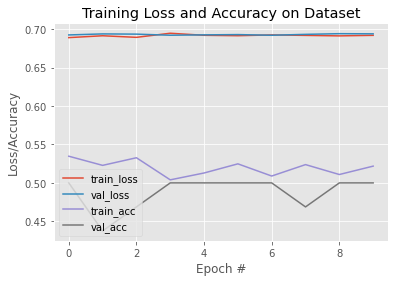

In [111]:
plot_history(history3)

# AUC PLOTS

In [58]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

### Architecture 1 ROC

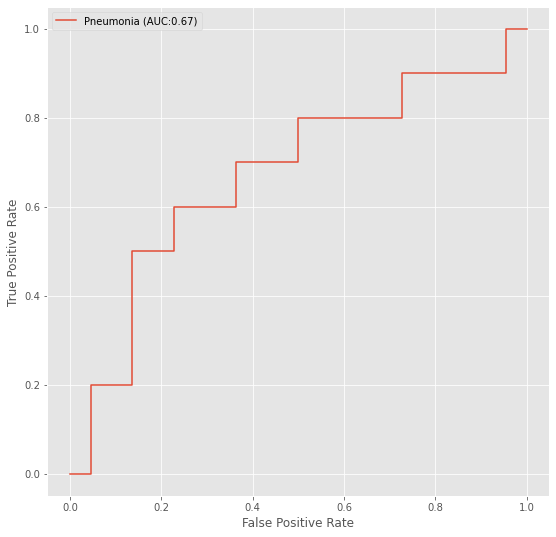

In [59]:
plot_auc(valY, pred_Y)

### Architecture 2 ROC

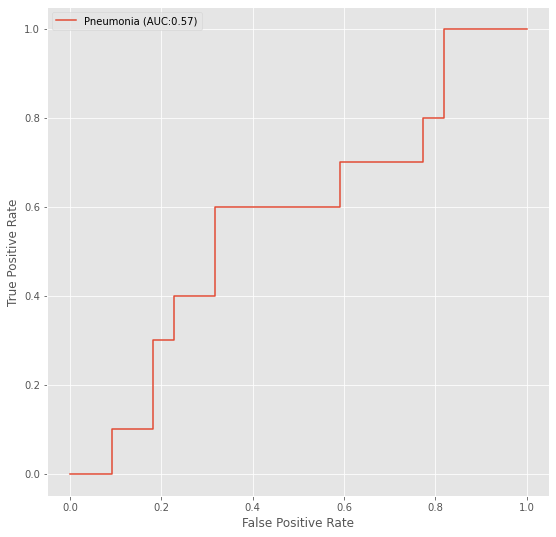

In [89]:
plot_auc(valY, pred_Y2)

### Architecture 3 ROC

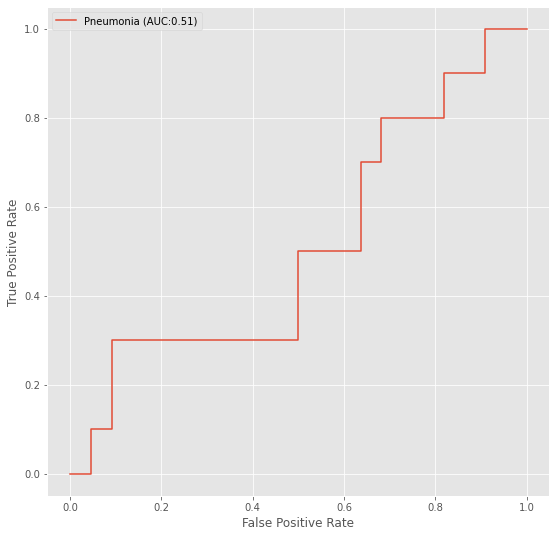

In [112]:
plot_auc(valY, pred_Y3)

# PR CURVE ,F1 SCORE AND THRESHOLDING

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [60]:
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)

### Architecture 1 Analysis

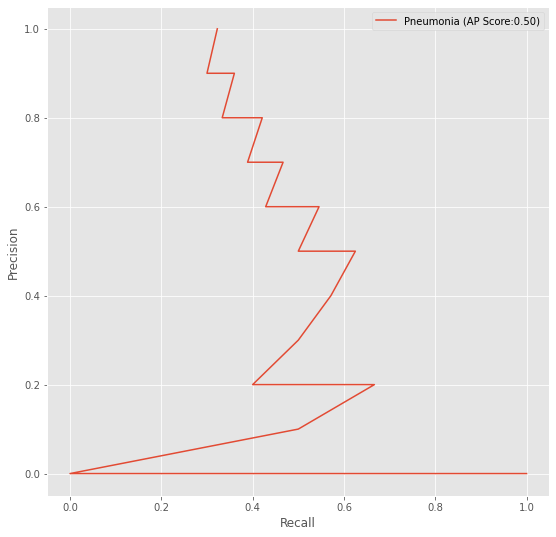

In [61]:
plot_pr(valY, pred_Y)

In [62]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

In [63]:
precision_value = 0.75
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.6666666666666666
Recall is: 0.2
Threshold is: 0.6440228
F1 Score is: 0.30769230769230765


In [64]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.3333333333333333
Recall is: 0.8
Threshold is: 0.45569378
F1 Score is: 0.47058823529411764


In [65]:
probs = pred_Y
t1 = (probs > 0.53)
t2 = (probs > 0.47)

In [66]:
a = np.asarray(t1).astype(int)
b= np.asarray(t2).astype(int)

In [67]:
a

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [68]:
a.ndim

2

In [69]:
a=a.flatten()

In [70]:
b=b.flatten()

In [71]:
a

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [72]:
# t1 = t1.replace(True,1).replace(False,0)
# t2 = t2.replace(True,1).replace(False,0)

In [73]:
 a=pd.Series(a)

In [74]:
 b=pd.Series(b)

In [75]:
a

0     0
1     0
2     0
3     0
4     1
5     0
6     0
7     1
8     1
9     0
10    1
11    1
12    0
13    0
14    0
15    1
16    0
17    1
18    1
19    1
20    1
21    0
22    0
23    1
24    1
25    1
26    0
27    0
28    0
29    0
30    1
31    0
dtype: int64

In [76]:

compare_t1 = (a == valY)
compare_t2 = (b == valY)

In [77]:
compare_t1

0      True
1      True
2      True
3      True
4     False
5      True
6      True
7      True
8      True
9      True
10    False
11     True
12     True
13    False
14     True
15    False
16     True
17    False
18    False
19     True
20     True
21    False
22     True
23    False
24     True
25    False
26     True
27     True
28    False
29    False
30    False
31     True
dtype: bool

In [78]:

print('Accuracy at threshold 1: ' + str(len(compare_t1[compare_t1])/len(pred_Y)))

Accuracy at threshold 1: 0.625


In [79]:
print('Accuracy at threshold 2: ' + str(len(compare_t2[compare_t2])/len(pred_Y)))

Accuracy at threshold 2: 0.5


###  Architecture 2 Analysis

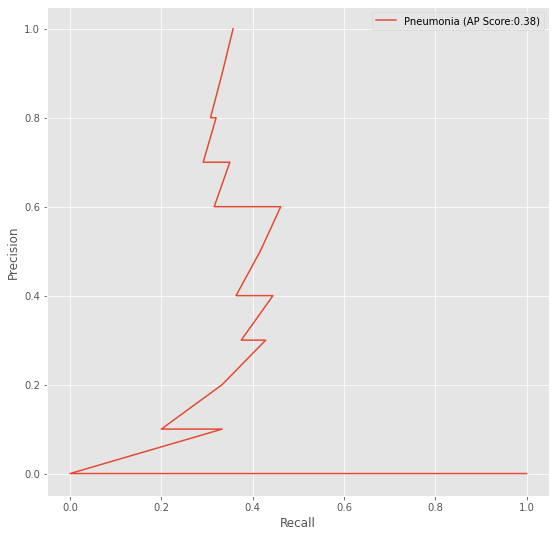

In [90]:
plot_pr(valY, pred_Y2)

In [91]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y2)

In [95]:

# Look at the threshold where precision is 0.73
precision_value = 0.73
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.46153846153846156
Recall is: 0.6
Threshold is: 0.3999641
F1 Score is: 0.5217391304347826


In [96]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.3076923076923077
Recall is: 0.8
Threshold is: 0.37276387
F1 Score is: 0.4444444444444444


In [98]:
probs = pred_Y2
t1 = (probs > 0.39 )
t2 = (probs > 0.37)

In [99]:
a = np.asarray(t1).astype(int)
b= np.asarray(t2).astype(int)

In [100]:
a=a.flatten()
b=b.flatten()

In [101]:
a=pd.Series(a)
b=pd.Series(b)

    

In [102]:
compare_t1 = (a == valY)
compare_t2 = (b == valY)

In [103]:
print('Accuracy at threshold 1: ' + str(len(compare_t1[compare_t1])/len(pred_Y2)))

Accuracy at threshold 1: 0.5


In [104]:
print('Accuracy at threshold 2: ' + str(len(compare_t2[compare_t2])/len(pred_Y2)))

Accuracy at threshold 2: 0.40625


### Architecture 3 Analysis

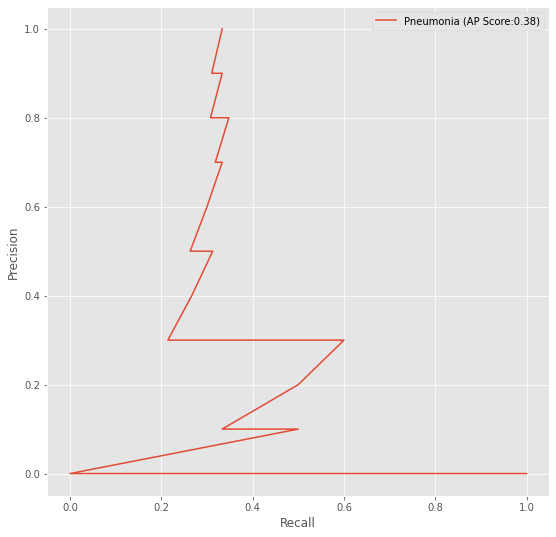

In [113]:
plot_pr(valY, pred_Y3)

In [114]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y3)

In [115]:
precision_value = 0.75
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.6
Recall is: 0.3
Threshold is: 0.50347394
F1 Score is: 0.4


In [116]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.3076923076923077
Recall is: 0.8
Threshold is: 0.49416763
F1 Score is: 0.4444444444444444


In [117]:
probs = pred_Y3
t1 = (probs > 0.5 )
t2 = (probs > 0.49)

In [118]:
a = np.asarray(t1).astype(int)
b= np.asarray(t2).astype(int)

In [119]:
a=a.flatten()
b=b.flatten()

In [120]:
a=pd.Series(a)
b=pd.Series(b)

In [121]:
compare_t1 = (a == valY)
compare_t2 = (b == valY)

In [122]:
print('Accuracy at threshold 1: ' + str(len(compare_t1[compare_t1])/len(pred_Y3)))

Accuracy at threshold 1: 0.5


In [123]:
print('Accuracy at threshold 2: ' + str(len(compare_t2[compare_t2])/len(pred_Y3)))

Accuracy at threshold 2: 0.3125


In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)